<a href="https://colab.research.google.com/github/JulianGlatzer/HplusML/blob/master/MassParameterisedNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Standard imports

In [0]:
region='ge6jge4b'
invertTestTrain=False

In [2]:
! rm -rf HplusML pandas_INC_{region}.h5
! wget https://jglatzer.web.cern.ch/jglatzer/hpml/pandas_INC_{region}.h5

--2019-03-21 15:58:06--  https://jglatzer.web.cern.ch/jglatzer/hpml/pandas_INC_ge6jge4b.h5
Resolving jglatzer.web.cern.ch (jglatzer.web.cern.ch)... 188.184.64.89, 2001:1458:201:a4::100:53
Connecting to jglatzer.web.cern.ch (jglatzer.web.cern.ch)|188.184.64.89|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51165780 (49M) [text/plain]
Saving to: ‘pandas_INC_ge6jge4b.h5’

pandas_INC_ge6jge4b 100%[===================>]  48.79M  4.25MB/s    in 14s     

2019-03-21 15:58:21 (3.49 MB/s) - ‘pandas_INC_ge6jge4b.h5’ saved [51165780/51165780]



In [3]:
! git clone https://github.com/JulianGlatzer/HplusML
import sys
sys.path.append("HplusML")
!cd HplusML; git pull origin

Cloning into 'HplusML'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 449 (delta 3), reused 82 (delta 3), pack-reused 363
Receiving objects: 100% (449/449), 20.52 MiB | 21.93 MiB/s, done.
Resolving deltas: 100% (187/187), done.
Already up to date.


In [4]:
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import HpAlgorithms
import HpMLUtils
import HpKerasUtils
import HpMLPlots
import HpHyperParameterOptimisation
import HpTrainingFrame

Using TensorFlow backend.


In [5]:
df_mc=pd.read_hdf('pandas_INC_'+region+'.h5', 'INC_'+region)
df_mc=df_mc[df_mc.process.apply(lambda x: True if x in ["ttlight","ttb","ttc"] or "Hp" in x else False)]
#print df_mc.process.shape
df_mc['process'].unique()

array(['ttlight', 'ttc', 'ttb', 'Hp200', 'Hp225', 'Hp250', 'Hp275',
       'Hp300', 'Hp350', 'Hp400', 'Hp500', 'Hp600', 'Hp700', 'Hp800',
       'Hp900', 'Hp1000', 'Hp1200', 'Hp1400', 'Hp1600', 'Hp1800',
       'Hp2000'], dtype=object)

# Prepare data for parameterised H+ classification

split into test and training data

In [6]:
from HpMLUtils import WeightedStandardScaler, summarizeFitData,MultiSBWeightsScaler
htf=HpTrainingFrame.HpTrainingFrame(df_mc)
X_train, X_test, X_eval, y_train, y_test,y_eval, w_train, w_test, w_eval=htf.prepare(hpmass="multi",addMass=True)
#summarizeFitData(X_train, y_train, w=w_train,categories=X_train.hpmass)

if invertTestTrain:
  X_tmp=X_train
  y_tmp=y_train
  w_tmp=w_train
  X_train=X_test
  y_train=y_test
  w_train=w_test
  X_test=X_tmp
  y_test=y_tmp
  w_test=w_tmp

print(X_train.hpmass.unique())

#sb=HpMLUtils.MultiSBWeightsScaler(backgroundclass=-1)
#sb.fit(X_train,X_train.hpmass, sample_weight=w_train)
#X_train=sb.transform(X_train,X_train.hpmass, sample_weight=w_train)
#w_train.groupby(X_train.hpmass).sum()


sb=MultiSBWeightsScaler(backgroundclass=-1)
sb.fit(X_train,X_train.hpmass, sample_weight=w_train)
X_train=sb.transform(X_train,X_train.hpmass, sample_weight=w_train)
X_test=sb.transform(X_test,X_test.hpmass, sample_weight=w_test)
w_train.groupby(y_train).sum()
summarizeFitData(X_train, y_train, w=w_train,categories=X_train.hpmass)

hpmass_train=X_train.hpmass.copy()
hpmass_test=X_test.hpmass.copy()

#change the hpmass for background to randomly assigned hpmass labels
from scipy.stats import rv_discrete

#1. first get the PDF from signal
signalsum=w_train[X_train.hpmass>0].sum()
xk=[]
pk=[]
for name, group in w_train.groupby(X_train.hpmass):
    if name>0:
        xk.append((-1)*name)
        pk.append(group.sum()/signalsum)

print(xk,pk)

#return
custm=rv_discrete(values=(xk,pk))
#print "before resetting hpmass", sorted(X_train.hpmass.unique())
X_train["hpmass"]=X_train.hpmass.apply(lambda x: x if x>0 else custm.rvs())
X_test["hpmass"]=X_test.hpmass.apply(lambda x: x if x>0 else custm.rvs())
#print "resetting hpmass", sorted(X_train.hpmass.unique())

print("the following is the difference between + and - mass")
print((w_train*((X_train.hpmass>0)-0.5)*2).groupby(X_train.hpmass.abs()).sum())
print("the following is the sum of weights")
print(w_train.groupby(X_train.hpmass).sum())

X_train.hpmass=X_train.hpmass.abs()
X_test.hpmass=X_test.hpmass.abs()
wss=WeightedStandardScaler()
wss.fit(X_train,sample_weight=w_train)
X_train=wss.transform(X_train)
X_test=wss.transform(X_test)
print("Summarizing train data after weighted standard scaler")
summarizeFitData(X_train, y_train, w=w_train,categories=hpmass_train)
print("Summarizing test data after weighted standard scaler")
summarizeFitData(X_test, y_test, w=w_test,categories=hpmass_test)


hpmasses=[200,225,250,275,300,350,400,500,600,700,800,900,1000,1200,1400,1600,1800,2000]
hpmass_mean=wss.mean_[-1]
hpmass_scale=wss.scale_[-1]
print(wss.mean_, wss.scale_)
for mass in hpmasses:
  print(mass, (mass-hpmass_mean)/hpmass_scale)

[1800 1000  600  700   -1  350 1200  275  200  300  800  500  250  225
 2000  900 1400 1600  400]
X.shape= (166812, 15) y.shape= (166812,)w.shape= (166812,)
columns= Index(['nJets', 'nBTags_70', 'pT_jet1', 'Mbb_MindR_70', 'pT_jet5', 'H1_all',
       'dRbb_avg_70', 'dRlepbb_MindR_70', 'Muu_MindR_70', 'HT_jets',
       'Mbb_MaxPt_70', 'Mbb_MaxM_70', 'Mjjj_MaxPt', 'Centrality_all',
       'hpmass'],
      dtype='object')
categories= [-1, 200, 225, 250, 275, 300, 350, 400, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000]

sum of weights per category
       all        1.0
        -1        0.5
       200 0.006535947712418301
       225 0.006535947712418302
       250 0.0065359477124183
       275 0.0065359477124183
       300 0.00980392156862745
       350 0.0130718954248366
       400 0.0196078431372549
       500 0.026143790849673203
       600 0.026143790849673196
       700 0.0261437908496732
       800 0.026143790849673207
       900 0.026143790849673207
      1000 0.039215

ok the columns include the H+ mass now

Now on to scaling the weights to have a flat distributiong in H+ mass

## Training the classifier

In [7]:
model16=HpKerasUtils.HpFeedForwardModel(configuration=[16,16],dropout=0.1, verbose=True, input_dim=15)
result16=model16.train((X_train.values, y_train.values, w_train.values),(X_test.values, y_test.values, w_test.values), patience=5)
model32=HpKerasUtils.HpFeedForwardModel(configuration=[32,32],dropout=0.1, verbose=True, input_dim=15)
result32=model32.train((X_train.values, y_train.values, w_train.values),(X_test.values, y_test.values, w_test.values), patience=5)
model64=HpKerasUtils.HpFeedForwardModel(configuration=[64,64],dropout=0.1, verbose=True, input_dim=15)
result64=model64.train((X_train.values, y_train.values, w_train.values),(X_test.values, y_test.values, w_test.values), patience=5)
model128=HpKerasUtils.HpFeedForwardModel(configuration=[128,128],dropout=0.1, verbose=True, input_dim=15)
result128=model128.train((X_train.values, y_train.values, w_train.values),(X_test.values, y_test.values, w_test.values), patience=5)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 545
Trainable params: 545
Non-trainable params: 0
_______________________

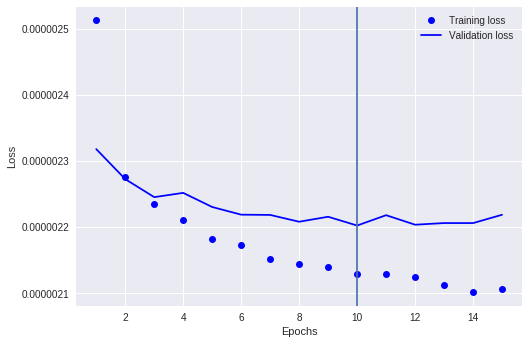

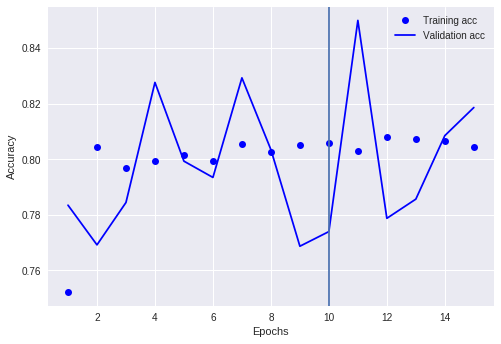

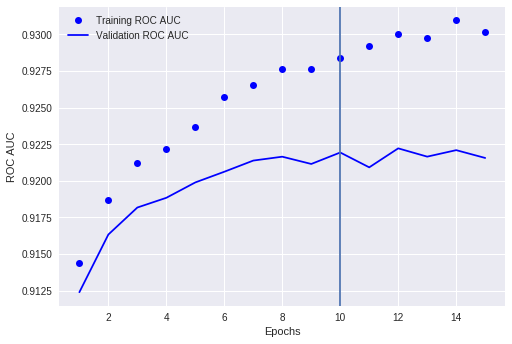

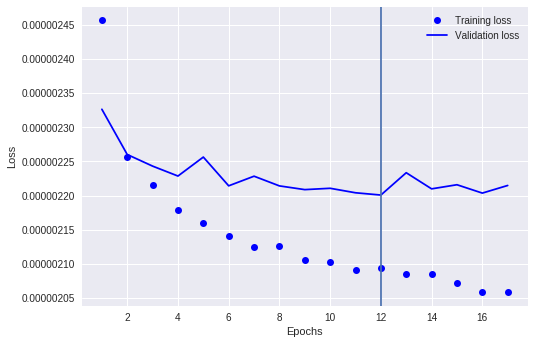

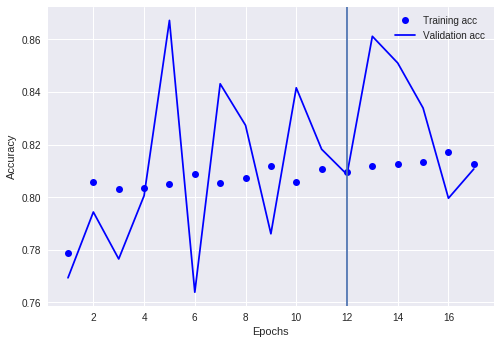

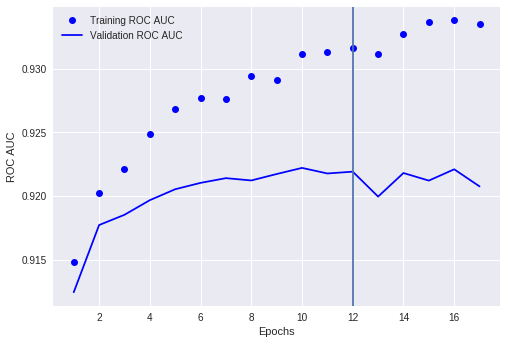

In [8]:
model64.plotTrainingValidation()
model128.plotTrainingValidation()

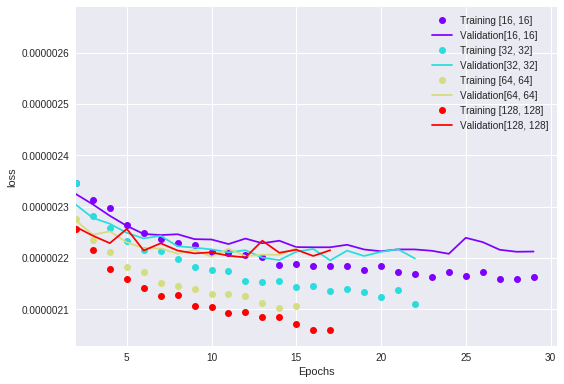

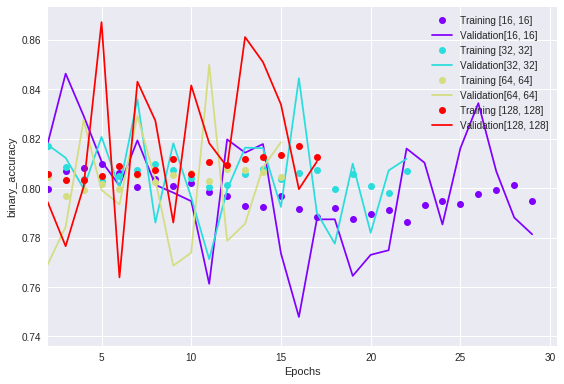

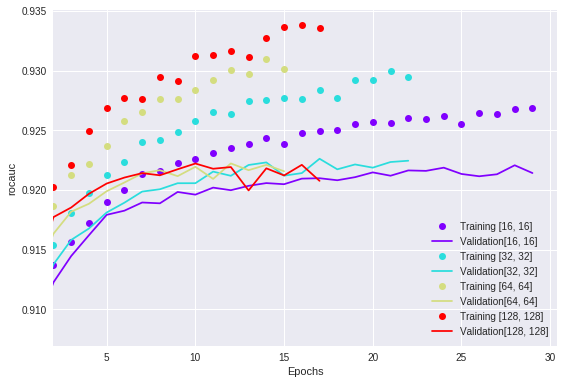

In [9]:
models={
    str([16,16]): model16,
    str([32,32]): model32,
    str([64,64]): model64,
    str([128,128]): model128
}
def plotByConfiguration(configurations=[[16,16],[32,32],[64,64],[128,128]], variable="loss", validationvariable="val_loss"):
  color=iter(plt.cm.rainbow(np.linspace(0,1,len(configurations))))
  
  if variable=="rocauc":
    index=-1
    for i,cb in enumerate(models[str(configurations[0])].callbacks):
      if hasattr(cb, 'roc') and hasattr(cb, 'roc_val'):
        index=i
  
  plt.figure()
  for configuration in configurations:

    if variable=="rocauc":
      loss_values=models[str(configuration)].callbacks[i].roc
      val_loss_values=models[str(configuration)].callbacks[i].roc_val
    else:
      loss_values=models[str(configuration)].history.history[variable]
      val_loss_values=models[str(configuration)].history.history[validationvariable]
    epochs=range(1,len(loss_values)+1)
    c=next(color)
    plt.plot(epochs, loss_values,"o", color=c,label="Training "+str(configuration))
    plt.plot(epochs, val_loss_values, color=c, label="Validation"+str(configuration))
    
  plt.xlim(left=2)
  plt.xlabel("Epochs")
  plt.ylabel(variable)
  plt.tight_layout()
  plt.legend()
  
 
plotByConfiguration()
plotByConfiguration(variable="binary_accuracy", validationvariable="val_binary_accuracy")
plotByConfiguration(variable="rocauc")

let's save the [64,64] model

In [0]:
from joblib import dump
if invertTestTrain:
  dump(wss, 'HplusML/models/massparameterisedNN_wss_'+region+'_train2mod1.joblib') 
  model64.model.save('HplusML/models/massparameterisedNN_'+region+'_train2mod1.h5')
else:
  dump(wss, 'HplusML/models/massparameterisedNN_wss_'+region+'_train2mod0.joblib') 
  model64.model.save('HplusML/models/massparameterisedNN_'+region+'_train2mod0.h5')

In [15]:
!cd HplusML/models/; tar cvfz massparameterisedNN_training.tar.gz massparameterisedNN_*.h5 massparameterisedNN_*.joblib

massparameterisedNN_ge6jge4b_train2mod0.h5
massparameterisedNN_ge6jge4b_train2mod1.h5
massparameterisedNN_wss_ge6jge4b_train2mod0.joblib
massparameterisedNN_wss_ge6jge4b_train2mod1.joblib


#Compare the results to the other methods (BDT/NN)

In [0]:
hpmasses=[200,225,250,275,300,350,400,500,600,700,800,900,1000,1200,1400,1600,1800,2000]

In [0]:
from sklearn.metrics import roc_auc_score
from keras.models import load_model
from joblib import load
from HpMLUtils import WeightedStandardScaler, summarizeFitData,MultiSBWeightsScaler

df_mc=pd.read_hdf('pandas_INC_'+region+'.h5', 'INC_'+region)
#df_mc=df_mc[df_mc.process.apply(lambda x: True if x in ["ttlight","ttb","ttc"] or "Hp" in x else False)]
htf=HpTrainingFrame.HpTrainingFrame(df_mc)

bdttrain=[]
bdttest =[]
bdtmassparamtrain=[]
bdtmassparamtest =[]
nntrain =[]
nntest  =[]
nnmassparamtrain=[]
nnmassparamtest =[]

bdttrainmassparammodel=load('HplusML/models/massparameterisedBDT_'+region+'_train2mod0.joblib')
bdttestmassparammodel=load('HplusML/models/massparameterisedBDT_'+region+'_train2mod1.joblib')
wsstrainmassparam=load('HplusML/models/massparameterisedNN_wss_'+region+'_train2mod0.joblib') 
wsstestmassparam =load('HplusML/models/massparameterisedNN_wss_'+region+'_train2mod1.joblib')  
nntrainmassparammodel=load_model('HplusML/models/massparameterisedNN_'+region+'_train2mod0.h5')
nntestmassparammodel =load_model('HplusML/models/massparameterisedNN_'+region+'_train2mod1.h5')
  
for hpmass in hpmasses:
  print(hpmass)
  X_train, X_test, X_eval, y_train, y_test,y_eval, w_train, w_test, w_eval=htf.prepare(hpmass=hpmass,addMass=True)
  
  sbtrain=MultiSBWeightsScaler(backgroundclass=0)
  sbtrain.fit(X_train,y_train, sample_weight=w_train)
  X_test =sbtrain.transform(X_test,y_test, sample_weight=w_test)
 
  sbtest=MultiSBWeightsScaler(backgroundclass=0)
  sbtest.fit(X_test,y_test, sample_weight=w_test)
  X_train=sbtest.transform(X_train,y_train, sample_weight=w_train)
  
  X_test.hpmass=hpmass
  X_testnohpmass=X_test.drop(["hpmass"],axis=1).copy() #copy is important as data is altered
  X_train.hpmass=hpmass
  X_trainnohpmass=X_train.drop(["hpmass"],axis=1).copy() #copy is important as data is altered
  
  # first calculate the standard BDT score
  bdttrainmodel=load('HplusML/models/standardBDT_'+str(hpmass)+'_'+region+'_train2mod0.joblib') 
  bdttestmodel =load('HplusML/models/standardBDT_'+str(hpmass)+'_'+region+'_train2mod1.joblib') 
  roc_bdt_test =roc_auc_score(y_test, bdttrainmodel.predict_proba(X_testnohpmass)[:,1], sample_weight=w_test)
  roc_bdt_train=roc_auc_score(y_train, bdttestmodel.predict_proba(X_trainnohpmass)[:,1], sample_weight=w_train)
  bdttrain.append(1.-roc_bdt_train)
  bdttest.append(1.-roc_bdt_test)
  
  # calculate the mass parameterised BDT score
  roc_bdtmassparam_test =roc_auc_score(y_test, bdttrainmassparammodel.predict_proba(X_test)[:,1], sample_weight=w_test)
  roc_bdtmassparam_train=roc_auc_score(y_train, bdttestmassparammodel.predict_proba(X_train)[:,1], sample_weight=w_train)
  bdtmassparamtrain.append(1.-roc_bdtmassparam_train)
  bdtmassparamtest.append(1.-roc_bdtmassparam_test)
  
  # calculate the standard NN activations
  wsstrain=load('HplusML/models/standardNN_wss_'+str(hpmass)+'_'+region+'_train2mod0.joblib') 
  wsstest =load('HplusML/models/standardNN_wss_'+str(hpmass)+'_'+region+'_train2mod1.joblib') 
  X_testnohpmass=wsstrain.transform(X_testnohpmass)
  X_trainnohpmass=wsstest.transform(X_trainnohpmass)
  nntrainmodel=load_model('HplusML/models/standardNN_'+str(hpmass)+'_'+region+'_train2mod0.h5')
  nntestmodel =load_model('HplusML/models/standardNN_'+str(hpmass)+'_'+region+'_train2mod1.h5')
  roc_nn_test =roc_auc_score(y_test, nntrainmodel.predict(X_testnohpmass.values), sample_weight=w_test)
  roc_nn_train=roc_auc_score(y_train, nntestmodel.predict(X_trainnohpmass.values), sample_weight=w_train)
  nntrain.append(1.-roc_nn_train)
  nntest.append(1.-roc_nn_test)
  
  # calculate the mass parameterised NN activations
  X_test =wsstrainmassparam.transform(X_test)
  X_train=wsstestmassparam.transform(X_train)
  roc_nnmassparam_test =roc_auc_score(y_test, nntrainmassparammodel.predict(X_test.values), sample_weight=w_test)
  roc_nnmassparam_train=roc_auc_score(y_train, nntestmassparammodel.predict(X_train.values), sample_weight=w_train)
  nnmassparamtrain.append(1.-roc_nnmassparam_train)
  nnmassparamtest.append(1.-roc_nnmassparam_test)

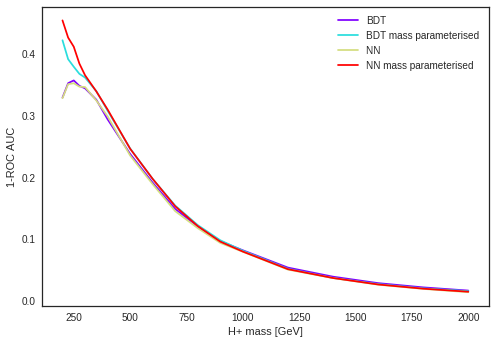

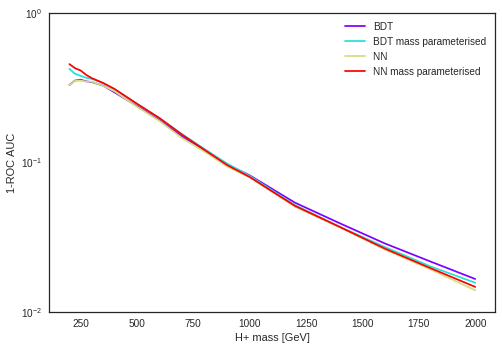

In [26]:
import matplotlib.ticker as ticker

plt.style.use('seaborn-white')

color=iter(plt.cm.rainbow(np.linspace(0,1,4)))

bdt=[0.5*sum(x) for x in zip(bdttest, bdttrain)]
bdtmassparam=[0.5*sum(x) for x in zip(bdtmassparamtest, bdtmassparamtrain)]
nn=[0.5*sum(x) for x in zip(nntest, nntrain)]
nnmassparam=[0.5*sum(x) for x in zip(nnmassparamtest, nnmassparamtrain)]

plt.plot(hpmasses, bdt, color=next(color), label="BDT")
plt.plot(hpmasses, bdtmassparam, color=next(color), label="BDT mass parameterised")
plt.plot(hpmasses, nn, color=next(color), label="NN ")
plt.plot(hpmasses, nnmassparam, color=next(color), label="NN mass parameterised")
plt.ylabel("1-ROC AUC")
plt.xlabel("H+ mass [GeV]")
plt.legend()

color=iter(plt.cm.rainbow(np.linspace(0,1,4)))
fig,ax=plt.subplots()
plt.semilogy(hpmasses, bdt, color=next(color), label="BDT")
plt.semilogy(hpmasses, bdtmassparam, color=next(color), label="BDT mass parameterised")
plt.semilogy(hpmasses, nn, color=next(color), label="NN ")
plt.semilogy(hpmasses, nnmassparam, color=next(color), label="NN mass parameterised")
plt.ylim([0.01,1])
plt.ylabel("1-ROC AUC")
plt.xlabel("H+ mass [GeV]")
plt.legend()

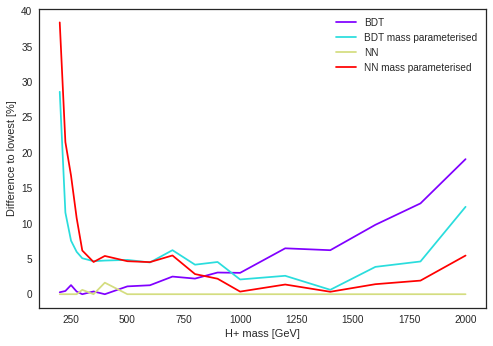

In [29]:
ratiobdt=[]
ratiobdtmassparam=[]
rationn=[]
rationnmassparam=[]
for i in range(len(hpmasses)):
  mn=min(bdt[i],bdtmassparam[i],nn[i],nnmassparam[i])
  ratiobdt.append((bdt[i]-mn)/mn*100)
  ratiobdtmassparam.append((bdtmassparam[i]-mn)/mn*100)
  rationn.append((nn[i]-mn)/mn*100)
  rationnmassparam.append((nnmassparam[i]-mn)/mn*100)

color=iter(plt.cm.rainbow(np.linspace(0,1,4)))
plt.plot(hpmasses, ratiobdt, color=next(color), label="BDT")
plt.plot(hpmasses, ratiobdtmassparam, color=next(color), label="BDT mass parameterised")
plt.plot(hpmasses, rationn, color=next(color), label="NN")
plt.plot(hpmasses, rationnmassparam, color=next(color), label="NN mass parameterised")
plt.ylabel("Difference to lowest [%]")
plt.xlabel("H+ mass [GeV]")
plt.legend()

We really have to do something against the mass parameterised methods blowing up at low masses. What can be done?

This is clearly the region where we have lower jet pt than background.
*  Do we need a higher complexity for the NN?
*  Do we need a higher weight for the low masses?
* Can we maybe pre-train on low masses only?



## Training the classifier at N-1 masses and checking at the remaining mass

In [0]:
from scipy.stats import rv_discrete
from joblib import dump
from HpMLUtils import WeightedStandardScaler, summarizeFitData,MultiSBWeightsScaler

sb=HpMLUtils.MultiSBWeightsScaler(backgroundclass=-1)

trainvalues_cross=[]
testvalues_cross=[]
for hpmass in hpmasses:
    print(hpmass)
    X_train, X_test, X_eval, y_train, y_test,y_eval, w_train, w_test, w_eval=htf.prepare(hpmass=hpmass, addMass=True, invertsignal=True)
    
    if invertTestTrain:
      X_tmp=X_train
      y_tmp=y_train
      w_tmp=w_train
      X_train=X_test
      y_train=y_test
      w_train=w_test
      X_test=X_tmp
      y_test=y_tmp
      w_test=w_tmp
    
    sb.fit(X_train,X_train.hpmass, sample_weight=w_train)
    X_train=sb.transform(X_train,X_train.hpmass, sample_weight=w_train)
    X_test =sb.transform(X_test, X_test.hpmass, sample_weight=w_test)
    
    signalsum=w_train[X_train.hpmass>0].sum()
    xk=[]
    pk=[]
    for name, group in w_train.groupby(X_train.hpmass):
        if name>0:
            xk.append((-1)*name)
            pk.append(group.sum()/signalsum)
    
    custm=rv_discrete(values=(xk,pk))
    X_train["hpmass"]=X_train.hpmass.apply(lambda x: x if x>0 else custm.rvs())
    X_test["hpmass"] =X_test.hpmass.apply(lambda x: x if x>0 else custm.rvs())
    X_train.hpmass=X_train.hpmass.abs()
    X_test.hpmass=X_test.hpmass.abs()
    
    wss=WeightedStandardScaler()
    wss.fit(X_train,sample_weight=w_train)
    X_train=wss.transform(X_train)
    X_test =wss.transform(X_test)
    
    model=HpKerasUtils.HpFeedForwardModel(configuration=[64,64],dropout=0.1, verbose=True, input_dim=15)
    result=model.train((X_train.values, y_train.values, w_train.values),(X_test.values, y_test.values, w_test.values), patience=5)

    if invertTestTrain:
      dump(wss, 'HplusML/models/massparameterisedNN_wss_allbut'+str(hpmass)+'_'+region+'_train2mod1.joblib') 
      model.model.save('HplusML/models/massparameterisedNN_allbut'+str(hpmass)+'_'+region+'_train2mod1.h5')
    else:
      dump(wss, 'HplusML/models/massparameterisedNN_wss_allbut'+str(hpmass)+'_'+region+'_train2mod1.joblib') 
      model.model.save('HplusML/models/massparameterisedNN_allbut'+str(hpmass)+'_'+region+'_train2mod0.h5')

In [0]:
!cd HplusML/models/; tar cvfz massparamerisedNN_training.tar.gz massparamerisedNN_*.h5 massparamerisedNN_*.joblib

Now evaluate all classifiers at masses where they weren't trained

In [0]:
#TODO

### Smoothness of score

one problem with the BDT is probably that the BDT score per event is not exactly smooth (probably quite ok as the distribution should be pretty smooth)

In [0]:
def decisionfunction(eventnumber):
  testmasses=np.linspace(200,2000, 1801)
  line1=X_test.iloc[eventnumber].copy()
  df = pd.DataFrame([line1]*len(testmasses))
  df["hpmass"]=testmasses
  y_pred=bdt.decision_function(df)
  plt.plot(testmasses, y_pred, '-')
  plt.xlabel('m(H+) [GeV]')
  plt.ylabel('BDT score')
  plt.show()
    
def nnactivation(eventnumber):
  testmasses=np.linspace(200,2000, 1801)
  line1=X_test.iloc[eventnumber].copy()
  df = pd.DataFrame([line1]*len(testmasses))
  df["hpmass"]=testmasses
  y_pred=nn.predict(wss.transform(df.values))
  plt.plot(testmasses, y_pred, '-')
  plt.xlabel('m(H+) [GeV]')
  plt.ylabel('NN activation')
  #plt.legend(loc="lower right")
  plt.show()

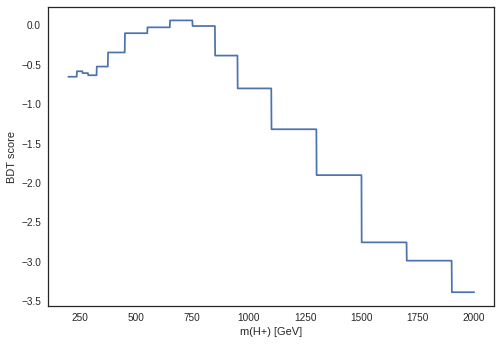

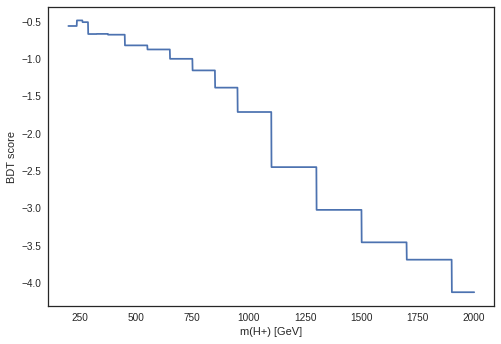

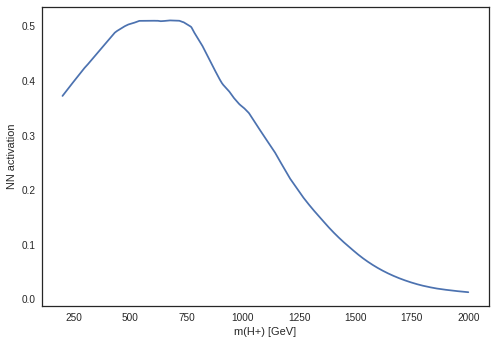

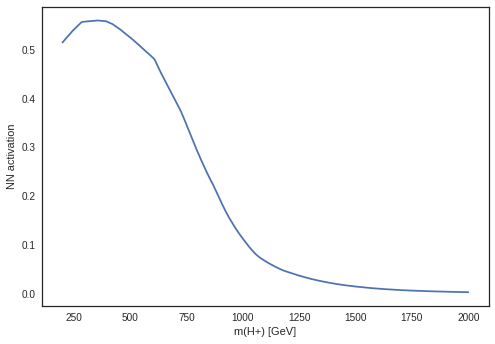

In [36]:
X_train, X_test, X_eval, y_train, y_test,y_eval, w_train, w_test, w_eval=htf.prepare(hpmass=300, addMass=True)

bdt=load('HplusML/models/massparameterisedBDT_'+region+'_train2mod0.joblib')

for i in range(0,2):
  decisionfunction(i)

wss=load('HplusML/models/massparameterisedNN_wss_'+region+'_train2mod0.joblib') 
nn=load_model('HplusML/models/massparameterisedNN_'+region+'_train2mod0.h5')
for i in range(0,2):
  nnactivation(i)

That's nice, having a smooth function certainly worked very well...